# Análise Univariada em SQL: Layoffs nas Empresas de Tecnologia (2022-2023)

Fonte dos dados: Kaggle

Link: https://www.kaggle.com/datasets/salimwid/technology-company-layoffs-20222023-data

## Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

## Adicionando ID's para as linhas e corrigindo o formato das datas para SQL (YYYY-MM-DD)

In [2]:
original_df = pd.read_csv('data/tech_layoffs_original.csv')

In [3]:
original_df['ID'] = original_df.index
def correct_date_format(date):
    splited_date = date.split('/')
    year = splited_date[2]
    month = splited_date[0]
    day = splited_date[1]
    if float(day) < 10:
        day = '0' + day
    if float(month) < 10:
        month = '0' + month
    return year + '-' + month + '-' + day

original_df['reported_date'] = original_df['reported_date'].apply(correct_date_format)

Ajeitando a ordem das colunas:

In [4]:
cols = original_df.columns.to_list()

In [5]:
cols = cols[-1:] + cols[:-1]

In [6]:
new_df = original_df[cols]

Passando para .csv:

In [7]:
new_df.to_csv('data/tech_layoffs_new.csv', index = False)

A partir desse arquivo, conseguimos criar um banco de dados SQLite para iniciarmos a conexão. As seguintes queries foram usadas para corrigir o banco de dados:

PRAGMA foreign_keys = 0;

CREATE TABLE sqlitestudio_temp_table AS SELECT *
                                          FROM data;

DROP TABLE data;

CREATE TABLE data (
    ID                            INTEGER PRIMARY KEY,
    company                       TEXT,
    total_layoffs                 INTEGER,
    impacted_workforce_percentage NUMERIC,
    reported_date                 TEXT,
    industry                      TEXT,
    headquarter_location          TEXT,
    sources                       TEXT,
    status                        TEXT,
    additional_notes              TEXT
);

INSERT INTO data (
                     ID,
                     company,
                     total_layoffs,
                     impacted_workforce_percentage,
                     reported_date,
                     industry,
                     headquarter_location,
                     sources,
                     status,
                     additional_notes
                 )
                 SELECT ID,
                        company,
                        total_layoffs,
                        impacted_workforce_percentage,
                        reported_date,
                        industry,
                        headquarter_location,
                        sources,
                        status,
                        additional_notes
                   FROM sqlitestudio_temp_table;

DROP TABLE sqlitestudio_temp_table;

PRAGMA foreign_keys = 1;

UPDATE data 
SET total_layoffs = NULL
WHERE total_layoffs = "Unclear";

UPDATE data
SET impacted_workforce_percentage = NULL
WHERE impacted_workforce_percentage = "Unclear";

## Conectando com o banco de dados SQLite

In [8]:
database = 'data/tech_layoffs.db'
conn = sqlite3.connect(database)

---

# Data Profiling: visão e estatísticas gerais

### Quantidade de linhas e colunas

In [9]:
cols_info = pd.read_sql('''PRAGMA TABLE_INFO(data)''', conn)

nrows = pd.read_sql('''SELECT COUNT(*) FROM data''', conn).values[0][0]
ncols = len(cols_info)
print(f'(linhas, colunas): ({nrows}, {ncols})')

(linhas, colunas): (489, 10)


### Descrição das colunas

In [10]:
cols_info

,cid,name,type,notnull,dflt_value,pk
0,0,ID,INTEGER,0,None,1
1,1,company,TEXT,0,None,0
2,2,total_layoffs,INTEGER,0,None,0
3,3,impacted_workforce_percentage,NUMERIC,0,None,0
4,4,reported_date,TEXT,0,None,0
5,5,industry,TEXT,0,None,0
6,6,headquarter_location,TEXT,0,None,0
7,7,sources,TEXT,0,None,0
8,8,status,TEXT,0,None,0
9,9,additional_notes,TEXT,0,None,0


- __ID__: chave primária inteira;

- __company__: empresa que realizou o layoff (demissão em massa);

- __total_layoffs__: número de funcionários demitidos até janeiro de 2023;

- __impacted_workforce_percentage__: porcentagem da força de trabalho total da empresa que foi demitida pelos layoffs;

- __reported_date__: data em que o primeiro layoff ou planos de layoff da empresa foram anunciados;

- __industry__: segmentos de atuação da empresa;

- __headquarter_location__: localização da sede da empresa;

- __sources__: fonte dos dados;

- __status__: se a empresa é pública ou privada.

- __additional_notes__: notas adicionais sobre o plano de layoffs da empresa.

### Valores iniciais e finais do dataframe

In [11]:
pd.read_sql('''SELECT * FROM data 
               LIMIT 5''', conn)

,ID,company,total_layoffs,impacted_workforce_percentage,reported_date,industry,headquarter_location,sources,status,additional_notes
0,0,C2FO,20.0,2,2022-12-09,"Fintech, payments","Leawood, KS",Kansas City Business Journal,Private,
1,1,VideoAmp,NaN,2,2022-09-19,Advertising platforms,Los Angeles,Company memo,Private,
2,2,Amperity,13.0,3,2022-08-20,"Saas, analytics",Seattle,Geekwire,Private,
3,3,Addepar,20.0,3,2023-01-18,"fintech, data analytics","Mountain View, CA",Fortune,Private,
4,4,Thirty Madison,24.0,3,2022-05-13,Health Care,New York,Axios,Private,"Per Axios, 22 of the employees laid off were f..."


In [12]:
pd.read_sql('''SELECT * FROM data 
               ORDER BY ID DESC
               LIMIT 5''', conn)

,ID,company,total_layoffs,impacted_workforce_percentage,reported_date,industry,headquarter_location,sources,status,additional_notes
0,488,Blueboard,NaN,None,2022-11-03,Enterprise Software,San Francisco,LinkedIn reports,Private,
1,487,Skillz,NaN,None,2022-08-29,"Mobile Apps, Gaming",San Francisco,Seeking Alpha,Public,
2,486,LivePerson,NaN,None,2022-09-15,Customer service,New York,LinkedIn,Public,
3,485,Oracle,NaN,None,2022-08-01,"SaaS, enterprise software",Austin,The Information,Public,The Information reported thousands of people w...
4,484,Salesforce,9090.0,None,2023-01-04,"enterprise tech, analytics",San Francisco,New York Times,Public,


## Análise univariada: estudando cada coluna separadamente

### total_layoffs

Valores na coluna e suas contagens:

In [13]:
pd.read_sql('''SELECT DISTINCT total_layoffs, COUNT(*) AS count
               FROM data
               GROUP BY total_layoffs
               ORDER BY total_layoffs''', conn)

,total_layoffs,count
0,NaN,182
1,5.0,1
2,7.0,1
3,10.0,1
4,11.0,1
...,...,...
145,9090.0,1
146,10000.0,1
147,11000.0,1
148,12000.0,1


Representando a distribuição dos valores (sem NULL) através de um boxplot:

{'whiskers': [<matplotlib.lines.Line2D at 0x2812eac8e10>,
 'caps': [<matplotlib.lines.Line2D at 0x2812ea8f8d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2812ea8ce10>],
 'medians': [<matplotlib.lines.Line2D at 0x2812ead8110>],
 'fliers': [<matplotlib.lines.Line2D at 0x2812ead8c10>],
 'means': []}

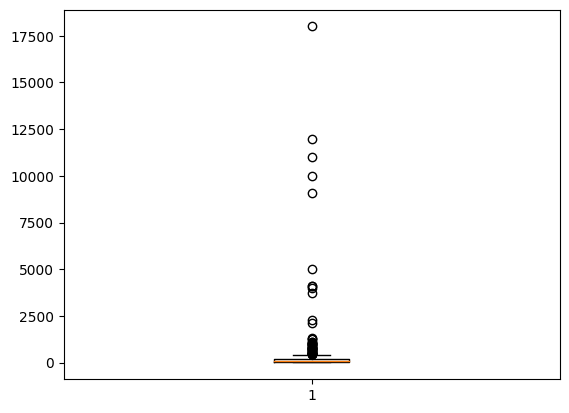

In [14]:
plot_data = pd.read_sql('''SELECT total_layoffs FROM data
                           WHERE total_layoffs IS NOT NULL''', conn)
plt.boxplot(plot_data)

Valores máximos e mínimos, e em quais empresas eles ocorreram:

In [15]:
pd.read_sql('''SELECT company, total_layoffs FROM data
               WHERE total_layoffs = (SELECT MAX(total_layoffs) FROM data)
               OR total_layoffs = (SELECT MIN(total_layoffs) FROM data)
               ORDER BY total_layoffs ASC''', conn)

,company,total_layoffs
0,Woven,5
1,Amazon,18000


Média de demissões:

In [16]:
pd.read_sql('''SELECT ROUND(AVG(total_layoffs), 0) AS mean_total_layoffs
               FROM data''', conn)

,mean_total_layoffs
0,450.0


### impacted_workforce_percentage

Valores na coluna e suas contagens:

In [57]:
pd.read_sql('''SELECT impacted_workforce_percentage, COUNT(*) AS count
               FROM data
               GROUP BY impacted_workforce_percentage
               ORDER BY impacted_workforce_percentage''', conn)

,impacted_workforce_percentage,count
0,NaN,133
1,1.0,2
2,2.0,3
3,3.0,8
4,4.0,4
5,5.0,20
6,6.0,12
7,7.0,15
8,8.0,12
9,9.0,9


Representando a distribuição dos valores (sem NULL) através de um histograma e de um boxplot:

Text(0.5, 1.0, 'Histograma')

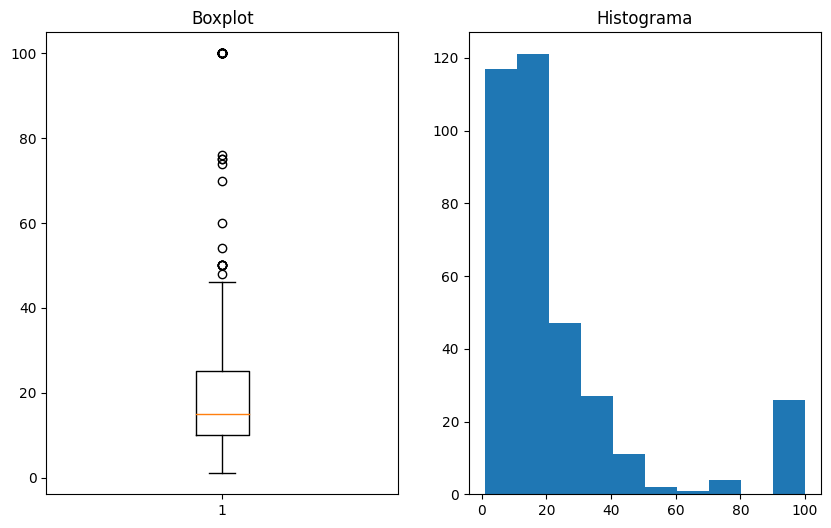

In [18]:
plot_data = pd.read_sql('''SELECT impacted_workforce_percentage FROM data
                           WHERE impacted_workforce_percentage IS NOT NULL''', conn)
fig, axs = plt.subplots(1, 2, figsize = (10,6))
axs[0].boxplot(plot_data)
axs[0].set_title('Boxplot')

axs[1].hist(plot_data)
axs[1].set_title('Histograma')

Valores máximo e mínimo, e em quais empresas eles ocorreram:

In [19]:
pd.read_sql('''SELECT company, impacted_workforce_percentage FROM data
               WHERE impacted_workforce_percentage = (SELECT MAX(impacted_workforce_percentage) FROM data)
               OR impacted_workforce_percentage = (SELECT MIN(impacted_workforce_percentage) FROM data)
               ORDER BY impacted_workforce_percentage ASC''', conn)

,company,impacted_workforce_percentage
0,F5,1
1,Affirm,1
2,Butler Hospitality,100
3,SummerBio,100
4,Reali,100
5,Fast,100
6,Protocol Media,100
7,WanderJaunt,100
8,Wyre,100
9,Lantern,100


Média de demissões:

In [20]:
pd.read_sql('''SELECT ROUND(AVG(impacted_workforce_percentage), 2)
               AS mean_impacted_workforce_percentage
               FROM data''', conn)

,mean_impacted_workforce_percentage
0,23.88


### reported_date

Anos em que ocorreram layoffs

In [49]:
pd.read_sql('''SELECT DISTINCT STRFTIME('%Y', reported_date) AS Layoff_Years
               FROM data
               WHERE STRFTIME('%Y', reported_date) <> 'None' 
               ORDER BY STRFTIME('%Y', reported_date)''', conn)

,Layoff_Years
0,2022
1,2023


Meses em que ocorreram layoffs

In [51]:
pd.read_sql('''SELECT DISTINCT STRFTIME('%m', reported_date) AS Layoff_Months
               FROM data
               WHERE STRFTIME('%m', reported_date) <> 'None' 
               ORDER BY STRFTIME('%m', reported_date)''', conn)

,Layoff_Months
0,01
1,02
2,03
3,04
4,05
5,06
6,07
7,08
8,09
9,10


Dias em que ocorreram layoffs

In [53]:
pd.read_sql('''SELECT DISTINCT STRFTIME('%d', reported_date) AS Layoff_Days
               FROM data
               WHERE STRFTIME('%d', reported_date) <> 'None' 
               ORDER BY STRFTIME('%d', reported_date)''', conn)

,Layoff_Days
0,01
1,02
2,03
3,04
4,05
5,06
6,07
7,08
8,09
9,10


### industry

Diferentes indústrias que demitiram:

In [54]:
pd.read_sql('''SELECT DISTINCT industry FROM data''', conn)

,industry
0,"Fintech, payments"
1,Advertising platforms
2,"Saas, analytics"
3,"fintech, data analytics"
4,Health Care
...,...
284,"Enterprise software, Management information sy..."
285,"cybersecurity, cloud infrastructure"
286,Autonomous vehicles
287,"Insurtech, machine learning"


Top 10 indústrias que demitiram mais de uma vez:

In [73]:
pd.read_sql('''SELECT industry, COUNT(*) AS industry_count
               FROM data
               GROUP BY industry
               HAVING industry_count > 1
               ORDER BY industry_count DESC
               LIMIT 10''', conn)

,industry,industry_count
0,Fintech,24
1,Health Care,17
2,PropTech,15
3,E-commerce,13
4,Cybersecurity,10
5,Proptech,9
6,InsurTech,7
7,FinTech,7
8,Cryptocurrency,7
9,Transportation,6


### headquarter_location

Diferentes localizações das empresas que demitiram:

In [74]:
pd.read_sql('''SELECT DISTINCT headquarter_location FROM data
               ORDER BY headquarter_location''', conn)

,headquarter_location
0,"Alameda, CA"
1,"Alpharetta, GA"
2,Atlanta
3,Austin
4,"Austin, TX"
...,...
129,"Walpole, MA"
130,"Washington, DC"
131,"Waterford, MI"
132,"Williston, VT"


Top 10 locais com base no número de empresas que demitiram:

In [72]:
pd.read_sql('''SELECT headquarter_location, COUNT(*) as location_count
               FROM data
               GROUP BY headquarter_location
               ORDER BY location_count DESC
               LIMIT 10''', conn)

,headquarter_location,location_count
0,San Francisco,136
1,New York,77
2,Seattle,21
3,Los Angeles,20
4,Boston,16
5,Chicago,12
6,"Austin, TX",6
7,San Diego,5
8,"Palo Alto, CA",5
9,"Mountain View, CA",5


### sources

Diferentes fontes dos dados:

In [76]:
pd.read_sql('''SELECT DISTINCT sources FROM data
               ORDER BY sources''', conn)

,sources
0,360dx
1,AMBCrypto
2,AdAge
3,Airtable
4,Alex Beller
...,...
216,WeWork
217,Wired
218,Wistia CEO
219,dot.LA


### status

Número de empresas privadas e públicas que demitiram:

In [94]:
pd.read_sql('''SELECT (SELECT COUNT(*) FROM data
                          WHERE status = 'Private') AS Private_Companies_Count,
                      (SELECT COUNT(*) FROM data
                       WHERE status = 'Public') AS Public_Companies_Count''', conn)

,Private_Companies_Count,Public_Companies_Count
0,370,119


### additional_notes

Obtendo as empresas que possuem notas adicionais:

In [96]:
pd.read_sql('''SELECT company, additional_notes FROM data
               WHERE additional_notes <> '' ''', conn)

,company,additional_notes
0,Thirty Madison,"Per Axios, 22 of the employees laid off were f..."
1,SundaySky,"Layoffs affect employees in the U.S., Israel, ..."
2,Sourcepoint,Company did not respond to a request to confir...
3,Nate,"Nate reportedly had two layoffs. In June, the ..."
4,Outschool,"Outschool laid off 31 people, or 18% of the co..."
5,Rasa,Rasa was founded in Berlin but moved its headq...
6,100 Thieves,More than a dozen employees were reportedly la...
7,Orbit,Orbit CEO Patrick Woods announced at least 14 ...
8,Cybereason,"Affected employees are in U.S., Israel, and Eu..."
9,Rad Power Bikes,"First round of layoffs was in April, second ro..."


---